In [8]:
from epsilon_transformers.process.processes import Mess3
from epsilon_transformers.process.MixedStateTree import MixedStateTree, MixedStateTreeNode
from epsilon_transformers.process.Process import _compute_emission_probabilities, _compute_next_distribution, Process
from collections import deque

In [11]:
mess3 = Mess3()
# msp_tree = mess3.derive_mixed_state_presentation(depth=11)


In [92]:
import numpy as np
def derive_mixed_state_presentation(process: Process, depth: int) -> MixedStateTree:
    starting_prob_vec = np.expand_dims(process.steady_state_vector, axis=0)
    tree_root = MixedStateTreeNode(state_prob_vector=starting_prob_vec, children=set(), path=[], emission_prob=0)
    nodes = set([tree_root])

    stack = deque([(tree_root, starting_prob_vec, [], 0)])
    while stack:
        current_node, state_prob_vector, current_path, current_depth = stack.pop()
        # print(state_prob_vector.shape, current_path)
        if current_depth < depth:
            emission_probs = _compute_emission_probabilities(process, state_prob_vector[-1])
            for emission in range(process.vocab_len):
                if emission_probs[emission] > 0:
                    next_state_prob_vector = np.expand_dims(
                        _compute_next_distribution(process.transition_matrix, state_prob_vector[-1], emission),
                        axis=0
                    )
                    child_path = current_path + [emission]

                    full_state_prob_history = (
                        np.concatenate([state_prob_vector, next_state_prob_vector], axis=0)
                        if current_depth > 0
                        else next_state_prob_vector
                    )

                    child_node = MixedStateTreeNode(
                        state_prob_vector=full_state_prob_history,
                        path=child_path,
                        children=set(),
                        emission_prob=emission_probs[emission]
                    )
                    current_node.add_child(child_node)

                    stack.append((child_node, full_state_prob_history, child_path, current_depth + 1))
        nodes.add(current_node)
    
    return MixedStateTree(root_node=tree_root, process=process.name, nodes=nodes, depth=depth)

In [93]:
a = derive_mixed_state_presentation(mess3, 10)

In [94]:
tree_paths, tree_beliefs = a.paths_and_belief_states

In [113]:
original_tree_paths, original_tree_beliefs = mess3.derive_mixed_state_presentation(10).paths_and_belief_states

In [115]:
original_tree_paths[1]

[2, 2, 2, 1, 2, 0, 1, 2, 2, 0]

In [ ]:
import torch

In [138]:
seq_len = 10
pairs = [(path, beliefs) for path, beliefs in zip(tree_paths, tree_beliefs) if len(path) == seq_len]
inputs = torch.stack([torch.tensor(path) for (path, beliefs) in pairs])
input_beliefs = torch.stack([torch.tensor(beliefs) for (path, beliefs) in pairs])

In [139]:
checkpoint_path = Path("/workspaces/cure/compmech-models/models/f6gnm1we-mess3-0.15-0.6/")
weights = torch.load(checkpoint_path / "998406400.pt")
device = torch.device("cuda:1")
with open(checkpoint_path / "train_config.json", "r") as f:
    required_fields = ['d_vocab', 'd_model', 'n_ctx', 'd_head', 'n_heads', 'n_layers']
    cfg_dict = {k: v for k, v in json.load(f).items() if k in required_fields}
    cfg_dict['n_head'] = cfg_dict.pop('n_heads')
    cfg_dict['d_mlp'] = 4 * cfg_dict['d_model']
    train_config = RawModelConfig(**cfg_dict)

model = train_config.to_hooked_transformer(device=device)
model.load_state_dict(weights)

<All keys matched successfully>

<class 'numpy.ndarray'>
(59049, 10, 3)


/opt/conda/lib/python3.12/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


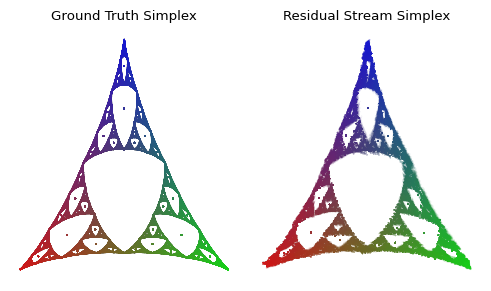

In [140]:
from sklearn.linear_model import LinearRegression

_, activations = model.run_with_cache(inputs, names_filter=lambda x: 'resid_post' in x)
def run_activation_to_beliefs_regression(activations, ground_truth_beliefs):

    # make sure the first two dimensions are the same
    assert activations.shape[0] == ground_truth_beliefs.shape[0]
    assert activations.shape[1] == ground_truth_beliefs.shape[1]

    # flatten the activations
    batch_size, n_ctx, d_model = activations.shape
    belief_dim = ground_truth_beliefs.shape[-1]
    print(type(activations))
    activations_flattened = activations.reshape(-1, d_model) # [batch * n_ctx, d_model]
    ground_truth_beliefs_flattened = ground_truth_beliefs.reshape(-1, belief_dim) # [batch * n_ctx, belief_dim]
    
    # run the regression
    regression = LinearRegression()
    regression.fit(activations_flattened, ground_truth_beliefs_flattened)

    # get the belief predictions
    belief_predictions = regression.predict(activations_flattened) # [batch * n_ctx, belief_dim]
    belief_predictions = belief_predictions.reshape(batch_size, n_ctx, belief_dim)

    return regression, belief_predictions

acts = activations['blocks.3.hook_resid_post'].cpu().detach().numpy()
# transformer_input_beliefs = transformer_input_beliefs.cpu().detach().numpy()
regression, belief_predictions = run_activation_to_beliefs_regression(acts, input_beliefs)
print(belief_predictions.shape)



from epsilon_transformers.analysis.activation_analysis import find_msp_subspace_in_residual_stream
from epsilon_transformers.process.processes import Mess3
from epsilon_transformers.visualization.plots import plot_ground_truth_and_evaluated_2d_simplex
from epsilon_transformers.visualization.plots import _project_to_simplex
import matplotlib.pyplot as plt
import seaborn as sns


belief_predictions_flattened = belief_predictions.reshape(-1, 3)
transformer_input_belief_flattened = input_beliefs.reshape(-1, 3)

# project to simplex
belief_true_projected = _project_to_simplex(transformer_input_belief_flattened)
belief_pred_projected = _project_to_simplex(belief_predictions_flattened)

rgb_colors =  transformer_input_belief_flattened#.cpu().numpy()
#rgb_colors = rgb_colors.astype(int)

sns.set_context("paper")
fig, axes = plt.subplots(1, 2, figsize=(5, 3))

# Plotting the true beliefs projected onto the simplex
axes[0].scatter(belief_true_projected[0], belief_true_projected[1], marker='.', c=rgb_colors, alpha=0.2, s=0.5)
axes[0].axis('off')
axes[0].set_title("Ground Truth Simplex")

# Plotting the predicted beliefs projected onto the simplex
axes[1].scatter(belief_pred_projected[0], belief_pred_projected[1], marker='.', c=rgb_colors, alpha=0.5, s=0.01)
axes[1].axis('off')
axes[1].set_title("Residual Stream Simplex")

# Adjust layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

